<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dynamic-Memory-Networks-for-Question-Answering" data-toc-modified-id="Dynamic-Memory-Networks-for-Question-Answering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dynamic Memory Networks for Question Answering</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Test" data-toc-modified-id="Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test</a></span></li><li><span><a href="#Accuracy" data-toc-modified-id="Accuracy-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Accuracy</a></span></li></ul></div>

usage: ipykernel_launcher.py [-h] [--foo FOO]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-422eddd7-bd5e-42e9-9f01-27f6d1040fa6.json


SystemExit: 2

/home/mouadh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Dynamic Memory Networks for Question Answering

- **[DMN Paper](https://arxiv.org/abs/1506.07285)**

In [30]:
dataset = np.load('/home/mouadh/Desktop/squad/data/train.npz')

In [31]:
context_char_idxs = torch.from_numpy(dataset['context_char_idxs']).long()

In [35]:
context_char_idxs.size()

torch.Size([129922, 400, 16])

In [68]:
ones = torch.ones((129922, 2), dtype=torch.int64)

In [69]:
ones

tensor([[1, 1],
        [1, 1],
        [1, 1],
        ...,
        [1, 1],
        [1, 1],
        [1, 1]])

In [71]:
ones.unsqueeze(2)

tensor([[[1],
         [1]],

        [[1],
         [1]],

        [[1],
         [1]],

        ...,

        [[1],
         [1]],

        [[1],
         [1]],

        [[1],
         [1]]])

In [25]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
from copy import deepcopy
import os
import re
import unicodedata
from torch.nn.utils.rnn import PackedSequence, pack_padded_sequence
# Fix a random seed to have reprodusable resaults
random.seed(1024)

flatten = lambda l: [item for sublist in l for item in sublist]
import spacy
nlp = spacy.blank("en")

In [27]:
s = nlp(" hello word")

In [28]:
s

 hello word

In [29]:
[token.text for token in s]


[' ', 'hello', 'word']

In [2]:
# Check GPU 
torch.cuda.is_available()

True

In [3]:
# Device name
torch.cuda.get_device_name()

'GeForce GTX 950M'

In [4]:
# Use GPU when it's possible
USE_CUDA = False# torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [5]:
# This function will create batches from the train data
def construct_batch(batch_size, train_data):
    '''
    This function will construct a batch from the data passed in input
    
    Arguments:
    batch_size--the size of the batch, int
    train_data--the data we will take out of it a batch
    '''
    # Shuffle randomly 
    random.shuffle(train_data)
    # Start index
    sindex = 0
    #End index
    eindex = batch_size
    # While end index is smaller than the data size do
    while eindex < len(train_data):
        # get a chunck of data from sindex to eindex
        batch = train_data[sindex: eindex]
        # Start index become end index
        sindex = eindex
        # move end index to the next position
        eindex = eindex + batch_size
        # concatinate results
        yield batch
    
    # Add the last chunk of data 
    if eindex >= len(train_data):
        # This smaller than batch_siez
        batch = train_data[sindex:]
        yield batch

In [6]:
def pad_to_batch(batch, w_to_ix): # for bAbI dataset
    # Get list of facts, question and answer
    fact,q,a = list(zip(*batch))
    # the size of the biggest list of facts
    max_fact = max([len(f) for f in fact])
    # the size of the maximum length of a fact
    max_len = max([f.size(1) for f in flatten(fact)])
    # The size of the maximum length of question
    max_q = max([qq.size(1) for qq in q])
    # The size of the maximum fact of answers
    max_a = max([aa.size(1) for aa in a])
    
    # 
    facts, fact_masks, q_p, a_p = [], [], [], []
    for i in range(len(batch)):
        # This will contain the padded strings from context
        fact_p_t = []
        for j in range(len(fact[i])):
            # If not the size of the max add padding
            if fact[i][j].size(1) < max_len:
                fact_p_t.append(torch.cat([fact[i][j], Variable(LongTensor([w_to_ix['<PAD>']] * (max_len - fact[i][j].size(1)))).view(1, -1)], 1))
            else:
                fact_p_t.append(fact[i][j])
                
        # To have the same size of facts! we append facts conatining only padding as words
        while len(fact_p_t) < max_fact:
            fact_p_t.append(Variable(LongTensor([w_to_ix['<PAD>']] * max_len)).view(1, -1))

        fact_p_t = torch.cat(fact_p_t)
        facts.append(fact_p_t)
        fact_masks.append(torch.cat([Variable(ByteTensor(tuple(map(lambda s: s==0, t.data))), 
                                        volatile=False) for t in fact_p_t]).view(fact_p_t.size(0), -1))

        if q[i].size(1) < max_q:
            q_p.append(torch.cat([q[i], Variable(LongTensor([w_to_ix['<PAD>']] * (max_q - q[i].size(1))))\
                                                  .view(1, -1)], 1))
        else:
            q_p.append(q[i])

        if a[i].size(1) < max_a:
            a_p.append(torch.cat([a[i], Variable(LongTensor([w_to_ix['<PAD>']] * (max_a - a[i].size(1)))).\
                                                    view(1, -1)], 1))
        else:
            a_p.append(a[i])

    questions = torch.cat(q_p)
    answers = torch.cat(a_p)
    question_masks = torch.cat([Variable(ByteTensor(tuple(map(lambda s: s==0, t.data))), volatile=False) 
                                                for t in questions]).view(questions.size(0), -1)
    
    return facts, fact_masks, questions, question_masks, answers

In [7]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

**Download tokenized train data but let's call it train to avoid confusion**

In [8]:
import pandas as pd
train = pd.read_csv('train.csv', index_col=0)

In [9]:
train.head()

,title,context,ids,question,is_impossible,answer_start,text,answer_end
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,False,269,in the late 1990s,286
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,False,207,singing and dancing,226
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,False,526,2003,530
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,False,166,"Houston, Texas",180
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,False,276,late 1990s,286


In [10]:
# New column contains the tokenized sentences
train['context_seq'] = train['context'].map(lambda c: nltk.sent_tokenize(c))

In [11]:
train.dropna(inplace=True)

In [12]:
train = train[['context_seq', 'question', 'text']]

In [13]:
# Select the same subject fot train and test
# train.loc[:500]

In [14]:
# Work on sample of the data! No enough memory GPU 
random.seed(1024)
test = train.loc[:1000].sample(n=30)
train = train.loc[:1000].sample(n=900)

In [15]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
def bAbI_data(data):
    
    data_p = []
    # Data is a list of lists: [context][question][answer]
    for d in data:
        data_inter = []
        cont = []
        for c in d[0]:
            # tokenize context
            cont.append(tokenizer.tokenize(c) + ['</s>'])
        data_inter.append(cont)
        # tokenize question
        data_inter.append(tokenizer.tokenize(d[1]) + ['?'])
        # tokenize answer
        data_inter.append(tokenizer.tokenize(d[2]) + ['</s>'])
        # append results 
        data_p.append(data_inter)
    return data_p

In [16]:
def get_context_question_answer(train):
    return list(train.values)

In [17]:
# Get a list of list containing [[context]][question][answer]
train_data = get_context_question_answer(train)

In [18]:
# Process the data to look like a bAbI data
train_data = bAbI_data(train_data)

In [19]:
train_data[0]

[[['Her',
   'fourth',
   'studio',
   'album',
   '4',
   'was',
   'released',
   'on',
   'June',
   '28',
   '2011',
   'in',
   'the',
   'US',
   '</s>'],
  ['4',
   'sold',
   '310',
   '000',
   'copies',
   'in',
   'its',
   'first',
   'week',
   'and',
   'debuted',
   'atop',
   'the',
   'Billboard',
   '200',
   'chart',
   'giving',
   'Beyoncé',
   'her',
   'fourth',
   'consecutive',
   'number',
   'one',
   'album',
   'in',
   'the',
   'US',
   '</s>'],
  ['The',
   'album',
   'was',
   'preceded',
   'by',
   'two',
   'of',
   'its',
   'singles',
   'Run',
   'the',
   'World',
   'Girls',
   'and',
   'Best',
   'Thing',
   'I',
   'Never',
   'Had',
   'which',
   'both',
   'attained',
   'moderate',
   'success',
   '</s>'],
  ['The',
   'fourth',
   'single',
   'Love',
   'on',
   'Top',
   'was',
   'a',
   'commercial',
   'success',
   'in',
   'the',
   'US',
   '</s>'],
  ['4',
   'also',
   'produced',
   'four',
   'other',
   'singles',
   'Part

In [21]:
fact,q,a = list(zip(*train_data))

In [22]:
# Construct the vocab
vocab = list(set(flatten(flatten(fact)) + flatten(q) + flatten(a)))

In [23]:
# Construct word2index dictionary
word2index={'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
# Construct index2word dictionary
index2word = {v:k for k, v in word2index.items()}

In [24]:
len(word2index)

3414

An important number of words!

In [25]:
def create_tensors_train(train_data):
    for t in train_data:
        for i,fact in enumerate(t[0]):
            t[0][i] = prepare_sequence(fact, word2index).view(1, -1)

        t[1] = prepare_sequence(t[1], word2index).view(1, -1)
        t[2] = prepare_sequence(t[2], word2index).view(1, -1)
    return t

In [26]:
tensors = create_tensors_train(train_data)

# Model

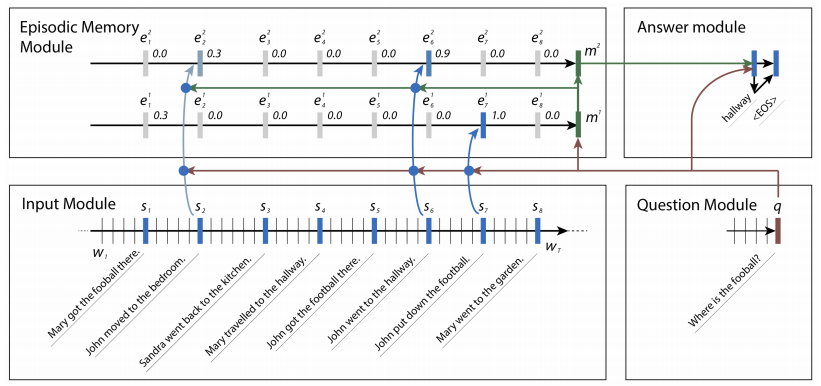

In [27]:
from IPython.display import Image
Image(filename='/home/mouadh/Desktop/SQuAD_V2.0/data/dmn.png')

In [28]:
# Construct the DMN test

class DMN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1):
        super(DMN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(input_size, hidden_size, padding_idx=0) #sparse=True)
        self.input_gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.question_gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        
        self.gate = nn.Sequential(
                            nn.Linear(hidden_size * 4, hidden_size),
                            nn.Tanh(),
                            nn.Linear(hidden_size, 1),
                            nn.Sigmoid()
                        )
        
        self.attention_grucell =  nn.GRUCell(hidden_size, hidden_size)
        self.memory_grucell = nn.GRUCell(hidden_size, hidden_size)
        self.answer_grucell = nn.GRUCell(hidden_size * 2, hidden_size)
        self.answer_fc = nn.Linear(hidden_size, output_size)
        
        self.dropout = nn.Dropout(dropout_p)
        
    def init_hidden(self, inputs):
        hidden = Variable(torch.zeros(1, inputs.size(0), self.hidden_size))
        return hidden.cuda() if USE_CUDA else hidden
    
    def init_weight(self):
        nn.init.xavier_uniform_(self.embed.state_dict()['weight'])
        
        for name, param in self.input_gru.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.question_gru.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.gate.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.attention_grucell.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.memory_grucell.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        for name, param in self.answer_grucell.state_dict().items():
            if 'weight' in name: nn.init.xavier_normal_(param)
        
        nn.init.xavier_normal_(self.answer_fc.state_dict()['weight'])
        self.answer_fc.bias.data.fill_(0)
        
    def forward(self, facts, fact_masks, questions, question_masks, num_decode, episodes=3, is_training=False):
        """
        facts : (B,T_C,T_I) / LongTensor in List # batch_size, num_of_facts, length_of_each_fact(padded)
        fact_masks : (B,T_C,T_I) / ByteTensor in List # batch_size, num_of_facts, length_of_each_fact(padded)
        questions : (B,T_Q) / LongTensor # batch_size, question_length
        question_masks : (B,T_Q) / ByteTensor # batch_size, question_length
        """
        # Input Module
        C = [] # encoded facts
        for fact, fact_mask in zip(facts, fact_masks):
            embeds = self.embed(fact)
            if is_training:
                embeds = self.dropout(embeds)
            hidden = self.init_hidden(fact)
            outputs, hidden = self.input_gru(embeds, hidden)
            real_hidden = []

            for i, o in enumerate(outputs): # B,T,D
                real_length = fact_mask[i].data.tolist().count(0) 
                real_hidden.append(o[real_length - 1])

            C.append(torch.cat(real_hidden).view(fact.size(0), -1).unsqueeze(0))
        
        encoded_facts = torch.cat(C) # B,T_C,D
        
        # Question Module
        embeds = self.embed(questions)
        if is_training:
            embeds = self.dropout(embeds)
        hidden = self.init_hidden(questions)
        outputs, hidden = self.question_gru(embeds, hidden)
        
        if isinstance(question_masks, torch.autograd.Variable):
            real_question = []
            for i, o in enumerate(outputs): # B,T,D
                real_length = question_masks[i].data.tolist().count(0) 
                real_question.append(o[real_length - 1])
            encoded_question = torch.cat(real_question).view(questions.size(0), -1) # B,D
        else: # for inference mode
            encoded_question = hidden.squeeze(0) # B,D
            
        # Episodic Memory Module
        memory = encoded_question
        T_C = encoded_facts.size(1)
        B = encoded_facts.size(0)
        for i in range(episodes):
            hidden = self.init_hidden(encoded_facts.transpose(0, 1)[0]).squeeze(0) # B,D
            for t in range(T_C):
                #TODO: fact masking
                #TODO: gate function => softmax
                z = torch.cat([
                                    encoded_facts.transpose(0, 1)[t] * encoded_question, # B,D , element-wise product
                                    encoded_facts.transpose(0, 1)[t] * memory, # B,D , element-wise product
                                    torch.abs(encoded_facts.transpose(0,1)[t] - encoded_question), # B,D
                                    torch.abs(encoded_facts.transpose(0,1)[t] - memory) # B,D
                                ], 1)
                g_t = self.gate(z) # B,1 scalar
                hidden = g_t * self.attention_grucell(encoded_facts.transpose(0, 1)[t], hidden) + (1 - g_t) * hidden
                
            e = hidden
            memory = self.memory_grucell(e, memory)
        
        # Answer Module
        answer_hidden = memory
        start_decode = Variable(LongTensor([[word2index['<s>']] * memory.size(0)])).transpose(0, 1)
        y_t_1 = self.embed(start_decode).squeeze(1) # B,D
        
        decodes = []
        for t in range(num_decode):
            answer_hidden = self.answer_grucell(torch.cat([y_t_1, encoded_question], 1), answer_hidden)
            decodes.append(F.log_softmax(self.answer_fc(answer_hidden),1))
        return torch.cat(decodes, 1).view(B * num_decode, -1)

# Train

In [29]:
HIDDEN_SIZE = 80
BATCH_SIZE = 64
LR = 0.001
EPOCH = 10
NUM_EPISODE = 3
EARLY_STOPPING = False

In [30]:
model = DMN(len(word2index), HIDDEN_SIZE, len(word2index))
model.init_weight()
if USE_CUDA:
    model = model.cuda()

loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [31]:
model = DMN(len(word2index), HIDDEN_SIZE, len(word2index))
model.init_weight()
if USE_CUDA:
    model = model.cuda()

loss_function = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [32]:
for epoch in range(EPOCH):
    losses = []
    if EARLY_STOPPING: 
        break
        
    for i,batch in enumerate(construct_batch(BATCH_SIZE, train_data)):
        facts, fact_masks, questions, question_masks, answers = pad_to_batch(batch, word2index)
        
        model.zero_grad()
        pred = model(facts, fact_masks, questions, question_masks, answers.size(1), NUM_EPISODE, True)
        loss = loss_function(pred, answers.view(-1))
        #losses.append(loss.data.tolist()[0])
        losses.append(loss.data.tolist())
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            print("[%d/%d] mean_loss : %0.2f" %(epoch, EPOCH, np.mean(losses)))
            
            if np.mean(losses) < 0.01:
                EARLY_STOPPING = True
                print("Early Stopping!")
                break
            losses = []

[0/10] mean_loss : 8.14
[1/10] mean_loss : 7.39
[2/10] mean_loss : 5.73
[3/10] mean_loss : 5.18
[4/10] mean_loss : 5.01
[5/10] mean_loss : 5.13
[6/10] mean_loss : 4.89
[7/10] mean_loss : 4.99
[8/10] mean_loss : 4.82
[9/10] mean_loss : 5.09


# Test

In [33]:
# Test_data will be an other chunck of data from train_data
test_data = test

In [34]:
test_data = get_context_question_answer(test_data)

In [35]:
test_data[1]

array([list(['Chopin arrived in Paris in late September 1831; he would never return to Poland, thus becoming one of many expatriates of the Polish Great Emigration.', 'In France he used the French versions of his given names, and after receiving French citizenship in 1835, he travelled on a French passport.', 'However, Chopin remained close to his fellow Poles in exile as friends and confidants and he never felt fully comfortable speaking French.', "Chopin's biographer Adam Zamoyski writes that he never considered himself to be French, despite his father's French origins, and always saw himself as a Pole."]),
       'What event was Frédéric a part of when he arrived in Paris during the later part of September in 1831?',
       'the Polish Great Emigration'], dtype=object)

In [36]:
test_data = bAbI_data(test_data)

In [37]:
test_data[1]

[[['Chopin',
   'arrived',
   'in',
   'Paris',
   'in',
   'late',
   'September',
   '1831',
   'he',
   'would',
   'never',
   'return',
   'to',
   'Poland',
   'thus',
   'becoming',
   'one',
   'of',
   'many',
   'expatriates',
   'of',
   'the',
   'Polish',
   'Great',
   'Emigration',
   '</s>'],
  ['In',
   'France',
   'he',
   'used',
   'the',
   'French',
   'versions',
   'of',
   'his',
   'given',
   'names',
   'and',
   'after',
   'receiving',
   'French',
   'citizenship',
   'in',
   '1835',
   'he',
   'travelled',
   'on',
   'a',
   'French',
   'passport',
   '</s>'],
  ['However',
   'Chopin',
   'remained',
   'close',
   'to',
   'his',
   'fellow',
   'Poles',
   'in',
   'exile',
   'as',
   'friends',
   'and',
   'confidants',
   'and',
   'he',
   'never',
   'felt',
   'fully',
   'comfortable',
   'speaking',
   'French',
   '</s>'],
  ['Chopin',
   's',
   'biographer',
   'Adam',
   'Zamoyski',
   'writes',
   'that',
   'he',
   'never',
   'co

In [38]:
def create_tensors_test(test_data):
    for t in test_data:
        for i, fact in enumerate(t[0]):
            t[0][i] = prepare_sequence(fact, word2index).view(1, -1)
    
        t[1] = prepare_sequence(t[1], word2index).view(1, -1)
        t[2] = prepare_sequence(t[2], word2index).view(1, -1)
    return test_data

In [39]:
test_data = create_tensors_test(test_data)

In [40]:
test_data[2]

[[tensor([[1405, 2679, 2851,  534, 2615, 3048,  811, 1545, 1521, 2933, 1708, 1281,
           1949, 2267,  540,   92, 3069, 1537,  418, 3251,  778,  599, 1916,    3]]),
  tensor([[ 940, 1979,   47,  421,  626, 1054,   35,  792, 3069, 3365, 2402,  647,
           3208, 2982, 1439, 1545, 1276, 2276, 2249, 3208, 2789, 1521, 2933, 2265,
           2510,  890,  811, 1545, 2267,  540,    3]])],
 tensor([[ 661, 3394,  792, 3223, 2615, 1202, 3069, 2276, 2249, 1174]]),
 tensor([[35,  3]])]

# Accuracy

In [41]:
accuracy = 0

In [42]:
def pad_to_fact(fact, x_to_ix): # this is for inference
    
    max_x = max([s.size(1) for s in fact])
    x_p = []
    for i in range(len(fact)):
        if fact[i].size(1) < max_x:
            x_p.append(torch.cat([fact[i], Variable(LongTensor([x_to_ix['<PAD>']] * (max_x - fact[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(fact[i])
        
    fact = torch.cat(x_p)
    fact_mask = torch.cat([Variable(ByteTensor(tuple(map(lambda s: s ==0, t.data))), volatile=False) for t in fact]).view(fact.size(0), -1)
    return fact, fact_mask

In [47]:
for t in test_data:
    fact, fact_mask = pad_to_fact(t[0], word2index)
    question = t[1]
    question_mask = Variable(ByteTensor([0] * t[1].size(1)), volatile=False).unsqueeze(0)
    answer = t[2].squeeze(0)
    
    model.zero_grad()
    pred = model([fact], [fact_mask], question, question_mask, answer.size(0), NUM_EPISODE)
    if pred.max(1)[1].data.tolist() == answer.data.tolist():
        accuracy += 1

print(accuracy/len(test_data) * 100)

0.0


In [56]:
t = random.choice(test_data)
fact, fact_mask = pad_to_fact(t[0], word2index)
question = t[1]
question_mask = Variable(ByteTensor([0] * t[1].size(1)), volatile=False).unsqueeze(0)
answer = t[2].squeeze(0)

model.zero_grad()
pred = model([fact], [fact_mask], question, question_mask, answer.size(0), NUM_EPISODE)

print("Facts : ")
print('\n'.join([' '.join(list(map(lambda x: index2word[x],f))) for f in fact.data.tolist()]))
print("")
print("Question : ",' '.join(list(map(lambda x: index2word[x], question.data.tolist()[0]))))
print("")
print("Answer : ",' '.join(list(map(lambda x: index2word[x], answer.data.tolist()))))
print("Prediction : ",' '.join(list(map(lambda x: index2word[x], pred.max(1)[1].data.tolist()))))

Facts : 
Chopin arrived in Paris in late September 1831 he would never return to Poland thus becoming one of many expatriates of the Polish Great Emigration </s> <PAD> <PAD>
In France he used the French versions of his given names and after receiving French citizenship in 1835 he travelled on a French passport </s> <PAD> <PAD> <PAD>
However Chopin remained close to his fellow Poles in exile as friends and confidants and he never felt fully comfortable speaking French </s> <PAD> <PAD> <PAD> <PAD> <PAD>
Chopin s biographer Adam Zamoyski writes that he never considered himself to be French despite his father s French origins and always saw himself as a Pole </s>

Question :  What event was Frédéric a part of when he arrived in Paris during the later part of September in 1831 ?

Answer :  the Polish Great Emigration </s>
Prediction :  </s> </s> </s> </s> </s>
